# Model-based attacks VS FGSM / iFGSM

## Preprocessing

In [18]:
# !pip install tsai
# !pip install optuna

In [97]:
SEED = 123
import random, os
import numpy as np
import torch

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tsai.models.all import ResCNN
import torch, torch.nn as nn, torch.nn.functional as F
from collections import defaultdict
import optuna

from typing import Optional
import tsai.models.all as mdls
import random


In [16]:

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### EarlyStopping utility

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, mode='min'):
        assert mode in ('min', 'max')
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            self.counter = 0
            return False
        improvement = (metric < self.best - self.min_delta) if self.mode == 'min' else (metric > self.best + self.min_delta)
        if improvement:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop


### Dataset preparation

In [5]:
TRAIN_PATH = Path('PowerCons_TRAIN.tsv')
TEST_PATH = Path('PowerCons_TEST.tsv')
BATCH_SIZE = 64
# EPOCHS = 50
# LR = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def load_powercon(path: Path):
    df = pd.read_csv(path, sep='\t', header=None)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y).astype(np.int64)
    return X, y_encoded, le.classes_

In [7]:
X_train, y_train, classes_ = load_powercon(TRAIN_PATH)
X_test, y_test, _ = load_powercon(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [8]:
class PowerConDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PowerConDataset(X_train, y_train)
test_ds = PowerConDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [9]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


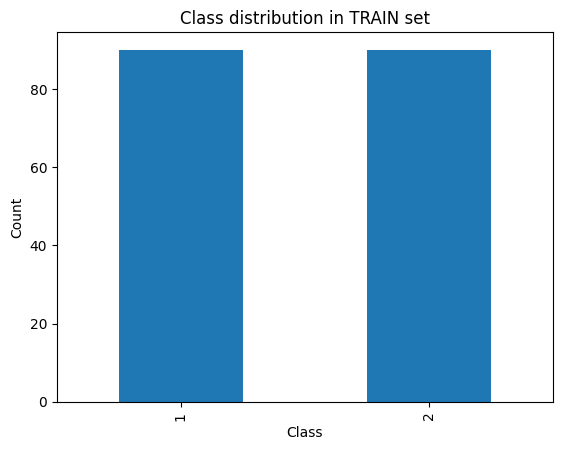

In [13]:
# check data-balance

df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

# 1. Считаем количество примеров каждого класса
label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')                # абсолютные значения
print(f'shares:\n{label_counts / len(df)}')      # доли

# 2. Быстрый бар-чарт
label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [14]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Classifiers

In [ ]:
def accuracy(logits, target):
    return (logits.argmax(1) == target).float().mean().item()

In [20]:
class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

### LSTM Classifier

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_classes, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
    def forward(self, x):
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


### ResCNN Classifier

In [32]:
class ResCNNClassifier(nn.Module):
    def __init__(self, n_classes, x_dim=1, activation_type='identity', rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}

        # NN-backbone: tsai.models.ResCNN
        self.body = ResCNN(c_in=x_dim, c_out=n_classes, **rescnn_kwargs)
        self.fin = Activation(activation_type)

    def forward(self, x):
        # (B,L,C) or (B,C,L) —> (B,C,L)
        if x.ndim == 3 and x.shape[1] != self.x_dim:   # (B,L,C)
            x = x.transpose(1, 2)
        return self.fin(self.body(x))                  # logits

### Training classifiers

In [22]:
def train_classifier(model,
                     train_loader,
                     val_loader=None,
                     epochs=50,
                     lr=1e-3,
                     weight_decay=0.,
                     device="cpu",
                     patience=5,
                     verbose_every=3):
    """
    returns: dict(history), best_val_loss, best_state_dict
    """
    model.to(device)
    opt      = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    stopper  = EarlyStopping(patience=patience, mode="min") if val_loader else None
    history  = defaultdict(list)
    best_wts = model.state_dict()
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        # ----- train -----
        model.train()
        loss_sum, acc_sum, n = 0., 0., 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss   = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item() * x.size(0)
            acc_sum  += (logits.argmax(1) == y).float().sum().item()
            n += x.size(0)

        train_loss = loss_sum / n
        train_acc  = acc_sum  / n
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----- validation -----
        if val_loader:
            model.eval()
            with torch.no_grad():
                loss_sum, acc_sum, n = 0., 0., 0
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss   = F.cross_entropy(logits, y)
                    loss_sum += loss.item() * x.size(0)
                    acc_sum  += (logits.argmax(1) == y).float().sum().item()
                    n += x.size(0)

            val_loss = loss_sum / n
            val_acc  = acc_sum  / n
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            if val_loss < best_val:
                best_val = val_loss
                best_wts = {k: v.cpu() for k, v in model.state_dict().items()}

            if stopper and stopper.step(val_loss):
                if verbose_every:
                    print(f"⏹ Early stopping on epoch {ep:02d}")
                break

        if verbose_every and ep % verbose_every == 0:
            msg = f"Epoch {ep:02d}: train_loss={train_loss:.4f} acc={train_acc:.4f}"
            if val_loader:
                msg += f" | val_loss={val_loss:.4f} acc={val_acc:.4f}"
            print(msg)

    model.load_state_dict(best_wts)
    return history, best_val, best_wts



#### train clf_LSTM

In [30]:
clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=50,
    lr=1e-3,
    weight_decay=0.,
    device="cpu",
    patience=4,
    verbose_every=1
)

Epoch 01: train_loss=0.7038 acc=0.5000 | val_loss=0.6997 acc=0.5000
Epoch 02: train_loss=0.6984 acc=0.5000 | val_loss=0.6964 acc=0.5000
Epoch 03: train_loss=0.6951 acc=0.5000 | val_loss=0.6931 acc=0.5000
Epoch 04: train_loss=0.6913 acc=0.5000 | val_loss=0.6899 acc=0.5000
Epoch 05: train_loss=0.6873 acc=0.5000 | val_loss=0.6866 acc=0.5000
Epoch 06: train_loss=0.6840 acc=0.5444 | val_loss=0.6830 acc=0.6056
Epoch 07: train_loss=0.6781 acc=0.5722 | val_loss=0.6792 acc=0.5944
Epoch 08: train_loss=0.6726 acc=0.6444 | val_loss=0.6743 acc=0.5833
Epoch 09: train_loss=0.6658 acc=0.6444 | val_loss=0.6672 acc=0.6000
Epoch 10: train_loss=0.6536 acc=0.6333 | val_loss=0.6546 acc=0.6222
Epoch 11: train_loss=0.6305 acc=0.6556 | val_loss=0.6259 acc=0.6500
Epoch 12: train_loss=0.5806 acc=0.6778 | val_loss=0.5623 acc=0.7000
Epoch 13: train_loss=0.5428 acc=0.7222 | val_loss=0.5040 acc=0.7556
Epoch 14: train_loss=0.4823 acc=0.7778 | val_loss=0.4681 acc=0.8000
Epoch 15: train_loss=0.4233 acc=0.8222 | val_los

#### train clf_resCNN

In [29]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=10,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.5544 acc=0.7111 | val_loss=0.5462 acc=0.7278
Epoch 02: train_loss=0.3574 acc=0.8333 | val_loss=0.6487 acc=0.5000
Epoch 03: train_loss=0.3632 acc=0.8611 | val_loss=0.5445 acc=0.6889
Epoch 04: train_loss=0.3204 acc=0.8611 | val_loss=0.3488 acc=0.8611
Epoch 05: train_loss=0.3257 acc=0.8500 | val_loss=0.3448 acc=0.8667
Epoch 06: train_loss=0.2927 acc=0.8833 | val_loss=0.3620 acc=0.8778
Epoch 07: train_loss=0.2881 acc=0.8722 | val_loss=0.3598 acc=0.8778
Epoch 08: train_loss=0.2564 acc=0.8889 | val_loss=0.3144 acc=0.8500
Epoch 09: train_loss=0.2593 acc=0.8833 | val_loss=0.3088 acc=0.8667
Epoch 10: train_loss=0.2433 acc=0.9111 | val_loss=0.3238 acc=0.8611


#### optuna for LSTM clf

In [35]:
def objective(trial):
    # --- hyperparams ---
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    clf_model = LSTMClassifier(n_classes, 
                               hidden_size=hidden_dim, 
                               dropout=dropout)

    history, _, _=  train_classifier(clf_model,
                     train_dl,
                     val_loader=test_dl,
                     epochs=50,
                     lr=lr,
                     weight_decay=0.,
                     device="cpu",
                     patience=patience,
                     verbose_every=1)
    

    return history['val_acc'][-1]


# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST_PARAMS:", study.best_params)


## Adversarial Attacks

In [58]:
class Attack:
    def __init__(self, eps: float, clamp=(-1, 1)):
        self.eps = eps
        self.clamp = clamp

# class ModelBasedAttack(Attack):
#     def __init__(self, surrogate, eps, clamp=(-1, 1)):
#         super().__init__(eps, clamp)
#         self.surr = surrogate.eval()

#     @torch.no_grad()
#     def __call__(self, model, x, y):
#         delta = self.eps * torch.tanh(self.surr(x))
#         return torch.clamp(x + delta, *self.clamp)

class ModelBasedAttack(Attack):
    def __init__(self, attacker, eps, clamp=None):
        super().__init__(eps, clamp)
        self.attacker = attacker.eval()

    @torch.no_grad()
    def __call__(self, model, x, y):
        # delta = self.eps * self.attacker(x).sign()
        delta = self.eps * torch.tanh(self.attacker(x))
        # print(f"L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
        x_adv = x + delta
        if not self.clamp is None:
          x_adv = torch.clamp(x_adv, *self.clamp)
        return x_adv

In [75]:
def train_atk_model(atk_model, 
                    victim, 
                    loader, 
                    eps=0.5, 
                    epochs=50, 
                    lr=1e-4, 
                    alpha_l2=1e-3, 
                    device='cpu', 
                    patience=4,
                    is_clamped=False,
                    is_debugged=False
                    ):
    atk_model.to(device)
    victim.to(device).eval()
    opt = torch.optim.Adam(atk_model.parameters(), lr)
    stopper = EarlyStopping(patience=patience, mode="max")
    for ep in range(1, epochs+1):
        atk_model.train()
        run_vloss, run_acc, n = 0., 0., 0

        
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            delta = eps * torch.tanh(atk_model(x))
            if is_clamped:
                delta = torch.clamp(delta, -1, 1)

            # x_adv = torch.clamp(x + delta, -1, 1)
            
            x_adv = x + delta
            logits = victim(x_adv)

            vloss = F.cross_entropy(logits, y)
            acc = (logits.argmax(1) == y).float().mean().item()
            reg = alpha_l2 * (delta**2).mean()
            loss = -(vloss - reg)
            if is_debugged:
                print(f'\nx={((x[0].detach().cpu()**2).mean())**0.5}')
                print(f'delta={((delta[0].detach().cpu()**2).mean())**0.5}')
                print(f'y={y.detach().cpu()[0]}|logits={logits.detach().cpu().argmax(1)[0]}')
                print(f'vloss = {vloss}| reg = {reg}')
        
                with torch.no_grad():
                    # ----- (2) % L2-нормы входа -----
                    # L2 посчитаем по каждому объекту, затем усредним
                    l2_delta = torch.norm(delta.view(delta.size(0), -1), p=2, dim=1)
                    l2_x_adv = torch.norm(x_adv.view(x_adv.size(0), -1), p=2, dim=1) + 1e-8
                    l2_x     = torch.norm(x.view(x.size(0), -1),     p=2, dim=1) + 1e-8
                    perc_l2_x_adv  = (l2_delta / l2_x_adv * 100).mean().item()
                    perc_l2_x  = (l2_x_adv / l2_x * 100).mean().item()

                print(f'\nL2:Δ/x_adv: {perc_l2_x_adv:6.2f}%   x_adv/x: {perc_l2_x:6.2f}%')

    
            opt.zero_grad()
            loss.backward()
            opt.step()
            run_vloss += vloss.item()*x.size(0)
            run_acc += acc * x.size(0)
            n += x.size(0)
        
        val_loss = run_vloss / n
        print(f'\nEpoch {ep:02d} | victim‑loss {val_loss:.4f} | acc {run_acc/n:.4f}')
        if stopper.step(val_loss):
            print(f'⏹ Early stopping at epoch {ep}')
            break
    torch.save(atk_model.state_dict(), 'surrogate_maxloss.pth')
    return val_loss, run_acc/n


### LSTM Attack

In [73]:
class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

class attack_LSTM(nn.Module):
    def __init__(self, hidden_dim=64, x_dim=1, activation_type='identity', dropout=0.25):
        super().__init__()
        self.rnn_inp = nn.LSTM(x_dim, hidden_dim, num_layers=3, batch_first=True, dropout=dropout)
        self.act = Activation(activation_type)
        # ! delete fc
        self.rnn_out = nn.LSTM(hidden_dim, x_dim, num_layers=3, batch_first=True, dropout=dropout)
        # self.fc = nn.Linear(hidden_dim, x_dim)
    def forward(self, data):
        x, _ = self.rnn_inp(data)
        x = self.act(x)
        x, _ = self.rnn_out(x)
        return x


#### train

In [ ]:

"""
best params:
{'eps': 1.371353432117841, 'lr': 0.001749500764834404, 
'alpha_l2': 0.000686630895888702, 'patience': 9, 
'hidden_dim': 128, 'dropout': 0.6}

"""
atk_LSTM = attack_LSTM(hidden_dim=128, dropout=0.6, x_dim=1, activation_type='tanh').to(device)
for p in clf_LSTM.parameters():
    p.requires_grad_(False)
clf_LSTM.eval()

eps_LSTM = 1.371353
train_atk_model(atk_LSTM, 
                clf_LSTM, 
                train_dl, 
                eps=eps_LSTM, 
                epochs=20, 
                lr=0.01749500, 
                alpha_l2=0.00068663089588, 
                device=device, 
                patience=9
)

#### optuna

In [76]:
def objective(trial):
    # --- гиперпараметры ---
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    
    atk_model = attack_LSTM(
        hidden_dim=hidden_dim, x_dim=1, 
        activation_type='tanh', dropout=dropout
    )

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc 

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

study.optimize(objective, n_trials=50, timeout=60*60)
print("BEST PARAMS:", study.best_params)


[I 2025-08-06 16:10:23,258] A new study created in memory with name: no-name-6d203448-a6fb-4e09-8df6-d3dac8acee36



Epoch 01 | victim‑loss 0.6245 | acc 0.7444

Epoch 02 | victim‑loss 0.6730 | acc 0.7444

Epoch 03 | victim‑loss 0.7288 | acc 0.7278

Epoch 04 | victim‑loss 0.7551 | acc 0.7056

Epoch 05 | victim‑loss 0.7911 | acc 0.6944

Epoch 06 | victim‑loss 0.8210 | acc 0.6778

Epoch 07 | victim‑loss 0.8537 | acc 0.6667

Epoch 08 | victim‑loss 0.8875 | acc 0.6667

Epoch 09 | victim‑loss 0.9215 | acc 0.6556

Epoch 10 | victim‑loss 0.9602 | acc 0.6500

Epoch 11 | victim‑loss 0.9975 | acc 0.6500

Epoch 12 | victim‑loss 1.0382 | acc 0.6389

Epoch 13 | victim‑loss 1.0760 | acc 0.6333

Epoch 14 | victim‑loss 1.1037 | acc 0.6278

Epoch 15 | victim‑loss 1.1414 | acc 0.6278

Epoch 16 | victim‑loss 1.1853 | acc 0.6278

Epoch 17 | victim‑loss 1.2202 | acc 0.6111

Epoch 18 | victim‑loss 1.2555 | acc 0.6167

Epoch 19 | victim‑loss 1.2890 | acc 0.5944

Epoch 20 | victim‑loss 1.3216 | acc 0.5833

Epoch 21 | victim‑loss 1.3638 | acc 0.5556

Epoch 22 | victim‑loss 1.3924 | acc 0.5333

Epoch 23 | victim‑loss 1.4291 |

[I 2025-08-06 16:12:05,177] Trial 0 finished with value: 0.4999999966886308 and parameters: {'eps': 1.8169467043486052, 'lr': 0.002249736677914726, 'alpha_l2': 0.034796749718056005, 'patience': 8, 'hidden_dim': 64, 'dropout': 0.5}. Best is trial 0 with value: 0.4999999966886308.



Epoch 50 | victim‑loss 1.9213 | acc 0.5000

Epoch 01 | victim‑loss 0.2481 | acc 0.8889

Epoch 02 | victim‑loss 0.2577 | acc 0.8722

Epoch 03 | victim‑loss 0.2780 | acc 0.8667

Epoch 04 | victim‑loss 0.2835 | acc 0.8611

Epoch 05 | victim‑loss 0.2915 | acc 0.8556

Epoch 06 | victim‑loss 0.2985 | acc 0.8500

Epoch 07 | victim‑loss 0.3052 | acc 0.8444

Epoch 08 | victim‑loss 0.3150 | acc 0.8333

Epoch 09 | victim‑loss 0.3218 | acc 0.8278

Epoch 10 | victim‑loss 0.3338 | acc 0.8222

Epoch 11 | victim‑loss 0.3434 | acc 0.8222

Epoch 12 | victim‑loss 0.3557 | acc 0.8167

Epoch 13 | victim‑loss 0.3676 | acc 0.8111

Epoch 14 | victim‑loss 0.3830 | acc 0.8111

Epoch 15 | victim‑loss 0.3970 | acc 0.8111

Epoch 16 | victim‑loss 0.4165 | acc 0.8056

Epoch 17 | victim‑loss 0.4378 | acc 0.8056

Epoch 18 | victim‑loss 0.4661 | acc 0.8056

Epoch 19 | victim‑loss 0.4893 | acc 0.7833

Epoch 20 | victim‑loss 0.5131 | acc 0.7778

Epoch 21 | victim‑loss 0.5469 | acc 0.7722

Epoch 22 | victim‑loss 0.5769 |

[I 2025-08-06 16:14:36,411] Trial 1 finished with value: 0.5222222261958652 and parameters: {'eps': 1.371353432117841, 'lr': 0.001749500764834404, 'alpha_l2': 0.000686630895888702, 'patience': 9, 'hidden_dim': 128, 'dropout': 0.6}. Best is trial 0 with value: 0.4999999966886308.



Epoch 50 | victim‑loss 1.5262 | acc 0.5222

Epoch 01 | victim‑loss 1.0953 | acc 0.6778

Epoch 02 | victim‑loss 1.1185 | acc 0.6667

Epoch 03 | victim‑loss 1.1357 | acc 0.6667

Epoch 04 | victim‑loss 1.1476 | acc 0.6667

Epoch 05 | victim‑loss 1.1569 | acc 0.6667

Epoch 06 | victim‑loss 1.1648 | acc 0.6667

Epoch 07 | victim‑loss 1.1704 | acc 0.6667

Epoch 08 | victim‑loss 1.1753 | acc 0.6667

Epoch 09 | victim‑loss 1.1793 | acc 0.6667

Epoch 10 | victim‑loss 1.1824 | acc 0.6667

Epoch 11 | victim‑loss 1.1863 | acc 0.6667

Epoch 12 | victim‑loss 1.1892 | acc 0.6667

Epoch 13 | victim‑loss 1.1914 | acc 0.6667

Epoch 14 | victim‑loss 1.1939 | acc 0.6667

Epoch 15 | victim‑loss 1.1962 | acc 0.6667

Epoch 16 | victim‑loss 1.1974 | acc 0.6667

Epoch 17 | victim‑loss 1.1987 | acc 0.6667

Epoch 18 | victim‑loss 1.2005 | acc 0.6611

Epoch 19 | victim‑loss 1.2016 | acc 0.6611

Epoch 20 | victim‑loss 1.2027 | acc 0.6611

Epoch 21 | victim‑loss 1.2039 | acc 0.6611

Epoch 22 | victim‑loss 1.2055 |

[I 2025-08-06 16:17:07,243] Trial 2 finished with value: 0.6555555568801033 and parameters: {'eps': 0.9111812645237938, 'lr': 0.006656673070486842, 'alpha_l2': 0.001904821460799289, 'patience': 9, 'hidden_dim': 128, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.4999999966886308.



Epoch 50 | victim‑loss 1.2186 | acc 0.6556

Epoch 01 | victim‑loss 0.1800 | acc 0.9222

Epoch 02 | victim‑loss 0.1821 | acc 0.9222

Epoch 03 | victim‑loss 0.1825 | acc 0.9222

Epoch 04 | victim‑loss 0.1836 | acc 0.9222

Epoch 05 | victim‑loss 0.1815 | acc 0.9278

Epoch 06 | victim‑loss 0.1832 | acc 0.9222


[I 2025-08-06 16:17:21,385] Trial 3 finished with value: 0.9277777698304918 and parameters: {'eps': 0.7879720326948566, 'lr': 0.003194537591761808, 'alpha_l2': 1.550978450549172e-05, 'patience': 3, 'hidden_dim': 64, 'dropout': 0.5}. Best is trial 0 with value: 0.4999999966886308.



Epoch 07 | victim‑loss 0.1834 | acc 0.9278
⏹ Early stopping at epoch 7

Epoch 01 | victim‑loss 0.2359 | acc 0.8833

Epoch 02 | victim‑loss 0.2432 | acc 0.8833

Epoch 03 | victim‑loss 0.2515 | acc 0.8778

Epoch 04 | victim‑loss 0.2615 | acc 0.8722

Epoch 05 | victim‑loss 0.2732 | acc 0.8778

Epoch 06 | victim‑loss 0.2868 | acc 0.8778

Epoch 07 | victim‑loss 0.3002 | acc 0.8667

Epoch 08 | victim‑loss 0.3204 | acc 0.8556

Epoch 09 | victim‑loss 0.3401 | acc 0.8556

Epoch 10 | victim‑loss 0.3630 | acc 0.8556

Epoch 11 | victim‑loss 0.3951 | acc 0.8389

Epoch 12 | victim‑loss 0.4309 | acc 0.8111

Epoch 13 | victim‑loss 0.4755 | acc 0.7944

Epoch 14 | victim‑loss 0.5266 | acc 0.7833

Epoch 15 | victim‑loss 0.5812 | acc 0.7833

Epoch 16 | victim‑loss 0.6336 | acc 0.7833

Epoch 17 | victim‑loss 0.6930 | acc 0.7667

Epoch 18 | victim‑loss 0.7462 | acc 0.7611

Epoch 19 | victim‑loss 0.7918 | acc 0.7500

Epoch 20 | victim‑loss 0.8281 | acc 0.7444

Epoch 21 | victim‑loss 0.8621 | acc 0.7444

Epo

[W 2025-08-06 16:21:46,880] Trial 4 failed with parameters: {'eps': 0.7214819635967462, 'lr': 0.006255101371387048, 'alpha_l2': 0.002390350478606417, 'patience': 9, 'hidden_dim': 256, 'dropout': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2657511/476704915.py", line 15, in objective
    val_loss, val_acc = train_atk_model(
  File "/tmp/ipykernel_2657511/3634958101.py", line 24, in train_atk_model
    delta = eps * torch.tanh(atk_model(x))
  File "/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_2657511/1461698294.py", line 24, in forward
    x, _ = self.rnn_inp(data)
  File "/home/u

KeyboardInterrupt: 

### ResCNN Attack

In [59]:
class ResCNNModel(nn.Module):
    def __init__(self, x_dim=1, output_dim=n_classes,
                 activation_type='identity',
                 rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}
        self.body = ResCNN(c_in=x_dim, c_out=output_dim, **rescnn_kwargs)
        self.fin = Activation(activation_type)
    def forward(self, x):
        if x.ndim == 3 and x.shape[1] != self.x_dim:
            x = x.transpose(1, 2)
        return self.fin(self.body(x))

class AttackCNN(nn.Module):
    def __init__(self, hidden_dim=128, x_dim=1, activation_type='tanh'):
        super().__init__()
        self.step_cnn = ResCNNModel(x_dim=x_dim, output_dim=hidden_dim, activation_type='identity')
        self.fc = nn.Linear(hidden_dim, x_dim)
        self.act = Activation(activation_type)
    def forward(self, x):
        B, L, C = x.shape
        x_flat = x.contiguous().view(B * L, 1, C)
        h = self.step_cnn(x_flat)
        h = h.view(B, L, -1)
        return self.fc(self.act(h))
        # return self.act(h)


#### train

In [93]:
atk_resCNN = AttackCNN().to(device)
atk_resCNN = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

''' 
#! training is very sensitive to random-seed
weights were obtained with the parameters:
{'eps': 1.9910549963365909, 'lr': 0.0021041627898080928,
'alpha_l2': 4.549583575912758e-05, 'patience': 6}
'''
weights_path = 'weights/surr_resCNNfc_CPU_0.28.pth'
atk_resCNN.load_state_dict(torch.load(weights_path, map_location=device))

eps_resCNN = 1.9910549963365909
train_atk_model(atk_resCNN, clf_resCNN, train_dl,
                eps=eps_resCNN, 
                epochs=1, lr=0.00021041627898080928, alpha_l2=4.549583575912758e-05, 
                device=device, patience=6, is_debugged=False)


Epoch 01 | victim‑loss 1.9133 | acc 0.3389


(1.9133474561903212, 0.33888889153798424)

#### optuna

In [65]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)

    atk_model = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh')

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


### PatchTST Attack

In [77]:
loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)           # длина последовательности
print("Sequence length =", seq_len)


Sequence length = 144


In [80]:
class BaseModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.self_supervised = False

class PatchTST(BaseModel):
    def __init__(self, activation_type: str = "sigmoid", **kwargs) -> None:
        super().__init__()
        self.model = mdls.PatchTST(**kwargs).float()
        self.final_activation = Activation(activation_type)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.transpose(1, 2)
        output = self.model(X)
        return self.final_activation(output).squeeze(-1)


class AttackPatchTST(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        x_dim: int = 1,
        activation_type: str = "tanh",
        patch_kwargs: Optional[dict] = None,
    ):
        super().__init__()

        patch_kwargs = patch_kwargs or {}
        # гарантируем нужный выход PatchTST
        patch_kwargs.update(dict(c_in=x_dim,
                                 c_out=hidden_dim,
                                 pred_dim=hidden_dim))

        self.step_model = PatchTST(activation_type="identity", **patch_kwargs)
        self.fc        = nn.Linear(hidden_dim, x_dim)
        self.act       = Activation(activation_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        h = self.step_model(x)          # (B, 1, 1, hidden_dim)

        h = h.view(B, -1)
        # либо h = h.squeeze(1).squeeze(1)

        h = h.unsqueeze(1).expand(-1, L, -1)   # (B, L, hidden_dim)
        return self.fc(self.act(h))            # (B, L, C)


#### train

In [96]:
patch_params = dict(
    seq_len=144,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=28,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

atk_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
)

eps_PatchTST = 1.52738926
train_atk_model(atk_PatchTST, clf_resCNN, train_dl,
                eps=eps_PatchTST, 
                epochs=50, lr=0.000202314, alpha_l2=0.000114732, 
                device=device, patience=8, is_debugged=False)


Epoch 01 | victim‑loss 1.8540 | acc 0.6111

Epoch 02 | victim‑loss 4.4021 | acc 0.3611

Epoch 03 | victim‑loss 5.0330 | acc 0.2889

Epoch 04 | victim‑loss 5.3508 | acc 0.2667

Epoch 05 | victim‑loss 5.5228 | acc 0.2444

Epoch 06 | victim‑loss 5.5586 | acc 0.2333

Epoch 07 | victim‑loss 5.6052 | acc 0.2167

Epoch 08 | victim‑loss 5.6341 | acc 0.2167

Epoch 09 | victim‑loss 5.6838 | acc 0.1944

Epoch 10 | victim‑loss 5.8215 | acc 0.1778

Epoch 11 | victim‑loss 5.8359 | acc 0.1778

Epoch 12 | victim‑loss 5.9873 | acc 0.1222

Epoch 13 | victim‑loss 6.1531 | acc 0.0889

Epoch 14 | victim‑loss 6.1499 | acc 0.0889

Epoch 15 | victim‑loss 6.2843 | acc 0.0667

Epoch 16 | victim‑loss 6.2096 | acc 0.0778

Epoch 17 | victim‑loss 6.3128 | acc 0.0667

Epoch 18 | victim‑loss 6.2822 | acc 0.0722

Epoch 19 | victim‑loss 6.2859 | acc 0.0778

Epoch 20 | victim‑loss 6.2994 | acc 0.0667

Epoch 21 | victim‑loss 6.2927 | acc 0.0778

Epoch 22 | victim‑loss 6.2913 | acc 0.0722

Epoch 23 | victim‑loss 6.2964 |

(6.297706656985813, 0.06666666674945089)

#### optuna

In [83]:
SEQ_LEN  = 144
X_DIM    = 1
DEVICE   = device
VICTIM   = clf_resCNN
TRAIN_DL = train_dl

def objective(trial: optuna.Trial):

    # atk params
    eps        = trial.suggest_float("eps",        0.5, 2.0,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e-2,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-2,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # architecture
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # main hyperparams 
    patch_len  = trial.suggest_int("patch_len", 8, 32, step=4)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # подготовим patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_atk_model(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc


# sampler = optuna.samplers.TPESampler()
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("BEST PARAMS:", study.best_params)


### FGSM && iFGSM

In [26]:
# class FGSMAttack(Attack):
#     def __call__(self, model, x, y):
#         x_req = x.clone().detach().requires_grad_(True)
#         loss = F.cross_entropy(model(x_req), y)
#         loss.backward()
#         delta = self.eps * x_req.grad.sign()
#         x_adv = torch.clamp(x + delta, *self.clamp)
#         return x_adv.detach()

# class iFGSMAttack(Attack):
#     def __init__(self, eps, n_iter=10, alpha=None, clamp=(-1, 1), rand_init=True):
#         super().__init__(eps, clamp)
#         self.n_iter = n_iter
#         self.alpha = alpha if alpha is not None else 1.25 * eps / n_iter
#         self.rand_init = rand_init

#     def _clip(self, x_adv, x_orig):
#         delta = torch.clamp(x_adv - x_orig, min=-self.eps, max=self.eps)
#         return torch.clamp(x_orig + delta, *self.clamp)

#     def __call__(self, model, x, y):
#         model.eval()
#         if self.rand_init:
#             x_adv = x + torch.empty_like(x).uniform_(-self.eps, self.eps)
#             x_adv = self._clip(x_adv, x).detach()
#         else:
#             x_adv = x.clone().detach()

#         for _ in range(self.n_iter):
#             x_adv.requires_grad_(True)
#             loss = F.cross_entropy(model(x_adv), y)
#             model.zero_grad()
#             loss.backward()
#             grad_sign = x_adv.grad.sign()
#             x_adv = x_adv + self.alpha * grad_sign
#             x_adv = self._clip(x_adv, x).detach()
#         return x_adv



In [110]:
class FGSMAttack(Attack):
    def __call__(self, model, x, y):
        x_req = x.clone().detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_req), y)
        loss.backward()
        delta = self.eps * x_req.grad.sign()
        # print(f"FGSM L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
        x_adv = x + delta
        if not self.clamp is None:
          x_adv = torch.clamp(x_adv, *self.clamp)
        return x_adv.detach()

class iFGSMAttack(Attack):
    def __init__(self, eps, n_iter=20, alpha=None, clamp=None,
                 rand_init=True, momentum=0.9):
        super().__init__(eps, clamp)
        self.n_iter, self.alpha = n_iter, alpha or 1.5*eps/n_iter
        self.rand_init, self.mu = rand_init, momentum

    def __call__(self, model, x, y):
        x_adv = x.detach()
        if self.rand_init:
            x_adv = x_adv + torch.empty_like(x).uniform_(-self.eps, self.eps)
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
        g = torch.zeros_like(x)
        for _ in range(self.n_iter):
            x_adv.requires_grad_(True)
            loss = F.cross_entropy(model(x_adv), y)
            model.zero_grad(); loss.backward()
            grad = x_adv.grad / x_adv.grad.abs().mean(dim=(1,2), keepdim=True)
            g = self.mu * g + grad
            x_adv = x_adv + self.alpha * g.sign()
            delta = torch.clamp(x_adv - x, min=-self.eps, max=self.eps)
            x_adv = x + delta
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
            x_adv = x_adv.detach()
        # print(f"iFGSM L2 norm = {torch.norm(x_adv - x, p=2)}, L_infty norm = {torch.norm(x_adv - x, p=float('inf'))}")
        return x_adv

## Сomparison of attacks

### Metrics

In [111]:
def preds_to_labels(logits: torch.Tensor) -> torch.Tensor:
    return logits.argmax(dim=1)

def fooling_rate(model, loader, attack, device='cpu'):
    model.eval()
    fooled, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds_orig = preds_to_labels(model(x))
    fooled, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds_orig = preds_to_labels(model(x).detach())
        x_adv = attack(model, x, y)
        preds_adv = preds_to_labels(model(x_adv).detach())
        fooled += (preds_adv != preds_orig).sum().item()
        total += x.size(0)
    return fooled / total

def efficiency_rate(model, loader, attack, device='cpu'):
    model.eval()
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        true_positives += ((preds_adv == 1) & (y == 1)).sum().item()
        false_positives += ((preds_adv == 1) & (y == 0)).sum().item()
        false_negatives += ((preds_adv == 0) & (y == 1)).sum().item()

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return 1 - f1


In [112]:

def accuracy_after_attack(model, loader, attack, device='cpu'):
    model.eval()
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        correct += (preds_adv == y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    return accuracy



In [113]:
eps_FGSM = 1
fgsm_attack  = FGSMAttack(eps_FGSM)
ifgsm_attack = iFGSMAttack(eps=eps_FGSM, n_iter=60)

mba_LSTM = ModelBasedAttack(atk_LSTM, eps_LSTM)
mba_resCNN = ModelBasedAttack(atk_resCNN, eps_resCNN)
mba_PatchTST = ModelBasedAttack(atk_PatchTST, eps_PatchTST)



In [ ]:
# print(f'eps = {EPS}')

test_loader = test_dl

attacks = {'Unattacked': lambda model, x, y: x, 
           'FGSM': fgsm_attack,
           'iFGSM10nonrand02': iFGSMAttack(eps=eps_FGSM, n_iter=10, rand_init=False, momentum=0.2),
           'LSTM': mba_LSTM,
           'resCNN': mba_resCNN,
           'PatchTST': mba_PatchTST}

clf_model = clf_LSTM
for name, atk in attacks.items():
    fl_rate = fooling_rate(clf_model, test_loader, atk, device=device)
    ef_rate = efficiency_rate(clf_model, test_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, test_dl, atk, device=device)
    print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')

Unattacked   fooling rate:  0.000,  efficiency metric:  0.065,  target accuracy after attack:  0.933
FGSM         fooling rate:  0.839,  efficiency metric:  0.905,  target accuracy after attack:  0.050
iFGSM10nonrand02 fooling rate:  0.828,  efficiency metric:  0.885,  target accuracy after attack:  0.061
LSTM         fooling rate:  0.417,  efficiency metric:  0.818,  target accuracy after attack:  0.550
resCNN       fooling rate:  0.883,  efficiency metric:  0.756,  target accuracy after attack:  0.172
PatchTST     fooling rate:  0.822,  efficiency metric:  0.799,  target accuracy after attack:  0.161


Fooling rate FGSM  : 0.133
Fooling rate iFGSM : 0.156
Fooling rate LSTM  : 0.144
Fooling rate CNN   : 0.144


### Vizualization of adversarial samples

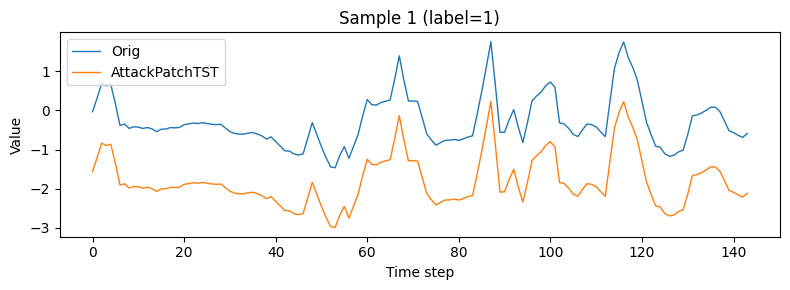

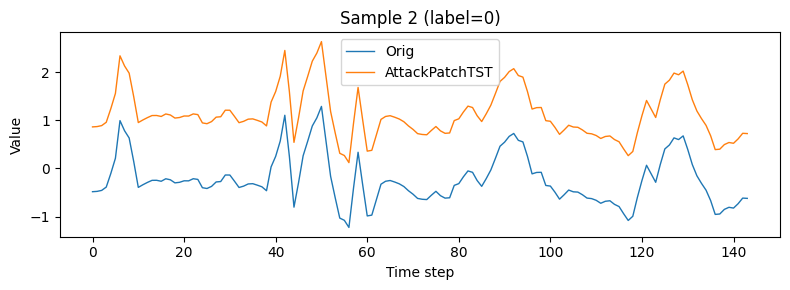

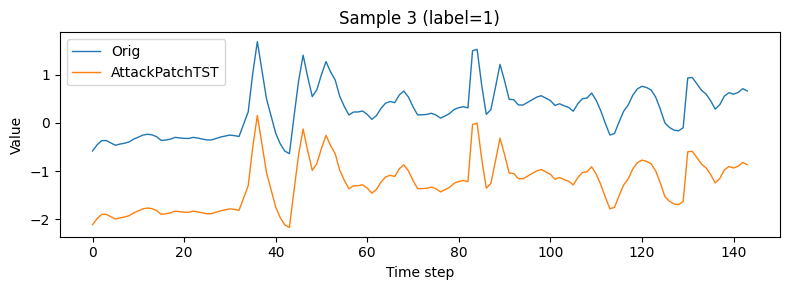

In [106]:
N_EXAMPLES = 3
FILTER = [2]
SURR_MODELS = [[atk_LSTM, atk_resCNN, atk_PatchTST][i] for i in FILTER]
EPS_LIST    = [[eps_LSTM, eps_resCNN, eps_PatchTST][i] for i in FILTER]



# выбираем batch-и, вытаскиваем по одному примеру
chosen = []
for xb, yb in test_dl:
    for i in range(xb.size(0)):
        chosen.append((xb[i], yb[i]))
    if len(chosen) >= 50:       # достаточно выборки для случайного выбора
        break

examples = random.sample(chosen, N_EXAMPLES)


for sample_idx, (x_orig, y_lbl) in enumerate(examples, 1):
    x_orig = x_orig.to(device).unsqueeze(0)
    x_np      = x_orig.squeeze().cpu().numpy()
    x_adv_np_list = []
    for i, atk_model in enumerate(SURR_MODELS):
        atk_model.eval()
        with torch.no_grad():
            delta = EPS_LIST[i] * torch.tanh(atk_model(x_orig))
            x_adv = x_orig + delta
            x_adv_np_list.append(x_adv.squeeze().cpu().numpy())

    plt.figure(figsize=(8, 3))
    plt.plot(x_np,     label='Orig', linewidth=1)
    for i, x_adv_np in enumerate(x_adv_np_list):
        plt.plot(x_adv_np, label=f'{SURR_MODELS[i].__class__.__name__}', linewidth=1)
    plt.title(f'Sample {sample_idx} (label={int(y_lbl)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
